<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/17_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Работа осуществляется с базой акции лукойла.**

1. Обучите сеть прогнозирования временных рядов для прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.
2. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).
3. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой




In [2]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
from tensorflow.keras import utils 

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler              # Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator     # для генерации выборки временных рядов
import tensorflow

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
base_data18_19 = pd.read_csv('/content/drive/My Drive/Акции Лукойл/18_19.csv', sep=';') # файлы №18 и №19
base_data16_17 = pd.read_csv('/content/drive/My Drive/Акции Лукойл/16_17.csv', sep=';')

In [7]:
base_data18_19.head(7)

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427
5,03.01.2018,10:05:00,3360.0,3363.5,3346.5,3353.0,3390
6,03.01.2018,10:06:00,3350.5,3351.5,3348.5,3350.0,412


In [8]:
base_data16_17.head(7)

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231
5,04.01.2016,10:05:00,2351.8,2351.8,2350.0,2350.0,934
6,04.01.2016,10:06:00,2350.0,2350.0,2346.9,2347.9,948


In [9]:
txt1 = base_data16_17.values[0]   # столбцы [0] и [1] не рассматриваю, предсказания осуществляю по столбцам с ценой и столбец [-1] количество
txt2 = base_data18_19.values[1]

print(txt1, txt2)

['04.01.2016' '10:00:00' 2351.0 2355.8 2350.0 2350.0 2547] ['03.01.2018' '10:01:00' 3355.0 3359.0 3353.0 3353.0 1624]


In [10]:
data16_17 = base_data16_17.iloc[:,2:7]  # кладу в data16_17 данные цен и кол-во проданных акций(избавился от дат)
data18_19 = base_data18_19.iloc[:,2:7]  # кладу в data18_19 данные цен и кол-во проданных акций(избавился от дат)

print(data16_17, "\n",data18_19)

          OPEN     MAX     MIN   CLOSE  VOLUME
0       2351.0  2355.8  2350.0  2350.0    2547
1       2352.9  2355.7  2350.0  2355.7     195
2       2355.6  2356.0  2351.4  2354.1     257
3       2354.5  2355.0  2351.2  2353.7     763
4       2353.1  2353.9  2353.1  2353.6     231
...        ...     ...     ...     ...     ...
263920  3320.5  3322.0  3316.5  3317.0    1227
263921  3318.0  3323.5  3317.0  3323.5     938
263922  3323.0  3324.0  3314.5  3314.5    1996
263923  3334.5  3334.5  3334.5  3334.5   83877
263924  3334.5  3334.5  3334.5  3334.5       2

[263925 rows x 5 columns] 
           OPEN     MAX     MIN   CLOSE  VOLUME
0       3341.0  3356.0  3340.0  3355.0    6088
1       3355.0  3359.0  3353.0  3353.0    1624
2       3351.5  3357.5  3351.5  3357.5     722
3       3354.5  3360.0  3354.5  3358.0    3034
4       3358.0  3360.0  3351.5  3360.0    1427
...        ...     ...     ...     ...     ...
217942  5183.5  5183.5  5183.5  5183.5   31523
217943  5183.5  5183.5  5183.5 

In [11]:
print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


**Объединяю data16_17 & data18_19 и создаю np массив**

In [12]:
data = data16_17.copy()                   # копирую data16_17, что бы не изменять сам файл
data = pd.concat([data16_17,data18_19])   # конкатенация
data = np.array(data)                     # перевожу в numpy массив
print("Pазмер слитой базы:", data.shape, "\n Kол-во временных отметок:", len(data))

Pазмер слитой базы: (481872, 5) 
 Kол-во временных отметок: 481872


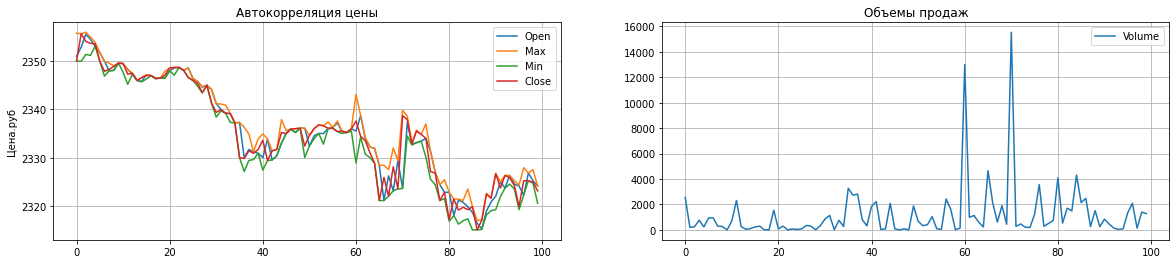

In [13]:
plt.figure(figsize=(20,4))
plt.subplot(121)

start = 0            # начало графика
stop = 100           # конец графика
chanelNames = ["Open", "Max", "Min", "Close"]
for i in range(4):
    plt.plot(data[start:start+stop,i], label=chanelNames[i]) 
    
plt.ylabel("Цена.руб")
plt.legend()
plt.title("Автокорреляция цены")
plt.grid()

plt.subplot(122)
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.title("Объемы продаж")
plt.grid()
plt.show()


**Задание 1: Обучите сеть прогнозирования временных рядов для прогнозирование на 10 шагов вперёд прямым способом**

In [14]:
xLen = 300                      # анализирую по 300 прошедшим точкам 
valLen = 30000                  # отрезок, по которому анализируем
stepForward = 10
allLen = data.shape[0]

trainLen = allLen-valLen        # pазмер тренировочной выборки
print("Размер обучающей выборки:", trainLen, "Размер проверочной выборки:", valLen, "Всего:", allLen )

Размер обучающей выборки: 451872 Размер проверочной выборки: 30000 Всего: 481872


In [15]:
def check_data():                    # проверяю корректность разбивки

    if trainLen + valLen == allLen:
        print("The size of data is correct")
    else:
        print("ERROR")

check_data()

The size of data is correct


In [16]:
xTrain,xTest = data[:trainLen - stepForward], data[trainLen+xLen+2: - stepForward + 1]  # обучающая  и проверочная выборки
print(xTrain.shape, xTest.shape)

(451862, 5) (29689, 5)


In [17]:
xScaler = MinMaxScaler()                # масштабирую по MinMaxScaler
xScaler.fit(xTrain)                     # учу модель только на Х, Y модель не должна видеть
xTrain = xScaler.transform(xTrain)      # масштабирую xTrain
xTest = xScaler.transform(xTest)        # масштабирую xTest

print(xTrain.shape,xTest.shape)         # данные нормализованны

(451862, 5) (29689, 5)


In [18]:
# для подготовки yTrain с 10 шагами - создаю датасет
yTrain = np.array([data[:trainLen, 3][i:i + stepForward] for i in range(trainLen - stepForward)])
yTest = np.array([data[trainLen + xLen + 2:,3][i:i + stepForward] for i in range(valLen - xLen - stepForward - 1)])

yScaler = StandardScaler()                # масштабирую по StandardScaler
yScaler.fit(yTrain)                       # учу модель
yTrain = yScaler.transform(yTrain)        # масштабирую yTrain
yTest = yScaler.transform(yTest)          # масштабирую yTest

print(yTrain.shape,yTest.shape)

(451862, 10) (29689, 10)


In [19]:
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, sampling_rate=1, batch_size=20)    # генератор для обучения            
testDataGen = TimeseriesGenerator(xTest, yTest,length=xLen, stride=1, batch_size=20)               # генератор для валидации 

In [20]:
print(trainDataGen[0][0].shape,trainDataGen[0][1].shape)

(20, 300, 5) (20, 10)


In [21]:
yTrain.shape[1] # это количество выходов предсказаний у сети (по количеству шагов)

10

**Задание №1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.**

In [22]:
modelDense = Sequential()                                                  # это сеть задания №1
modelDense.add(Dense(150,input_shape = (xLen,5), activation="relu" ))      # 5 - количество каналов(столбцов)
modelDense.add(Dense(100, activation="relu"))
modelDense.add(Flatten())
modelDense.add(Dense(yTrain.shape[1], activation="linear"))
# modelDense.add(10, activation="linear"))

modelDense.compile(loss="mse", optimizer=Adam(lr=1e-4))

In [23]:
history = modelDense.fit_generator(trainDataGen, epochs=20, verbose=0, validation_data = testDataGen)
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["loss"][19], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_loss"][19], 3))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


cредняя абсолютная ошибка на обучающем наборе: 0.0
cредняя абсолютная ошибка на проверочном наборе: 0.0


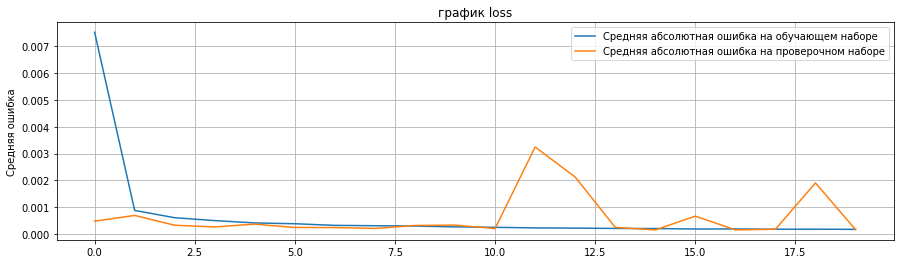

In [24]:
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_loss"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.ylabel("Средняя ошибка")
plt.legend()
plt.grid()
plt.title("график loss")
plt.show()

**Обработка для отображения корреляции**

In [25]:
def getPred(currModel, xVal, yVal, yScaler):                        # функция результатов прогнозирования(currModel - это сеть)

    predVal = yScaler.inverse_transform(currModel.predict(xVal))    # результат 
    yValUnscaled = yScaler.inverse_transform(yVal)                  # результат в исходном виде
          
    return (predVal, yValUnscaled)

In [26]:
def showPredict(start, step, channel, predVal, yValUnscaled):    # функция графиков результатов прогнозирования
                                                                 # start - точка начала графика
                                                                 # step - длина графика, которую отрисовываю
                                                                 # channel - какой канал(столбец) отрисовываю
    plt.figure(figsize=(15,4))
    plt.plot(predVal[start:start+step, channel], label="Прогноз")
    plt.plot(yValUnscaled[start:start+step, channel], label="Базовый ряд")
    plt.xlabel("Время")
    plt.ylabel("Значение Close")
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
def correlate(a, b):                     # функция корреляции дух одномерных векторов

    ma = a.mean()                        # Среднее значение первого вектора
    mb = b.mean()                        # Среднее значение второго вектора
    mab = (a*b).mean()                   # Среднее значение произведения векторов
    sa = a.std()                         # Среднеквадратичное отклонение первого вектора
    sb = b.std()                         # Среднеквадратичное отклонение второго вектора
    
    val = 1                              # корреляция
    if (sa > 0) & (sb > 0):
        val = (mab-ma*mb) / (sa*sb)
    return val

In [28]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):   # функция корреляции прогноза и реальности
                                                            # channels - по каким каналам(столбцам) отображать 
                                                            # corrSteps - количество шагов смещать сигнал назад для рассчёта корреляции
  
    for ch in channels:
      corr = [] 
      yLen = yValUnscaled.shape[0]                         # размер проверочной выборки

      for i in range(corrSteps):

          corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

      own_corr = [] 


      for i in range(corrSteps):

          own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

      plt.figure(figsize=(15,4))
      plt.plot(corr, label="Предсказание на" + str(ch+1) + "шаг")
      plt.plot(own_corr, label="Эталон")

    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
DataGen = TimeseriesGenerator(xTest, yTest,length=xLen, sampling_rate=1,  batch_size=len(xTest))  # генератор проверочной выборки
xVal = []                                                                                         # размер batch_size равен длине выборки
yVal = []
for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [30]:
xVal.shape

(1, 29389, 300, 5)

**Задание №2: Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях)**

In [31]:
currModel = modelDense       # прогноз modelDense
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

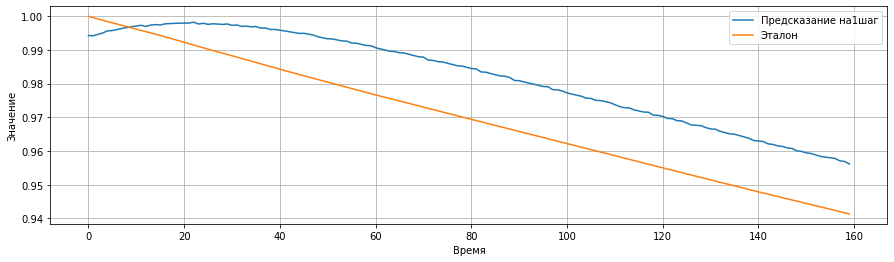

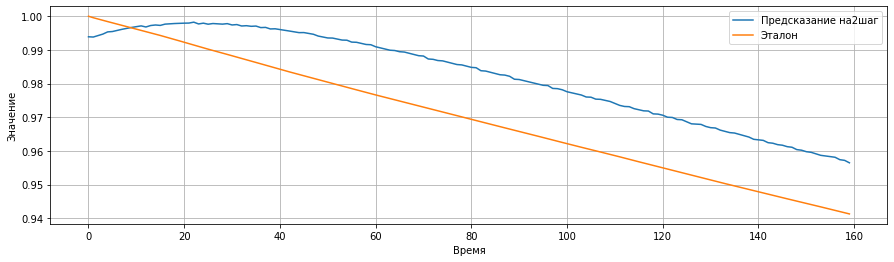

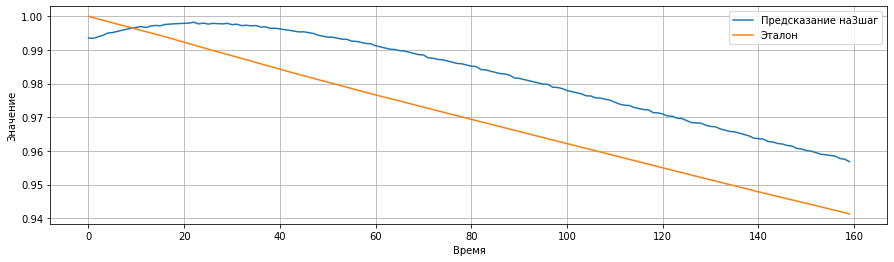

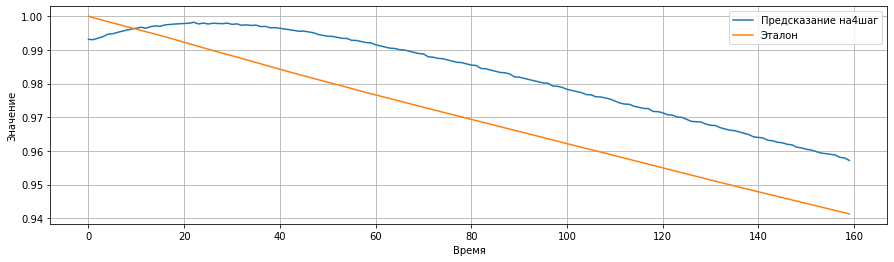

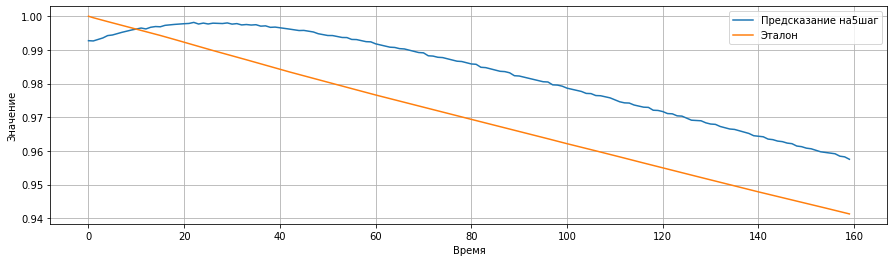

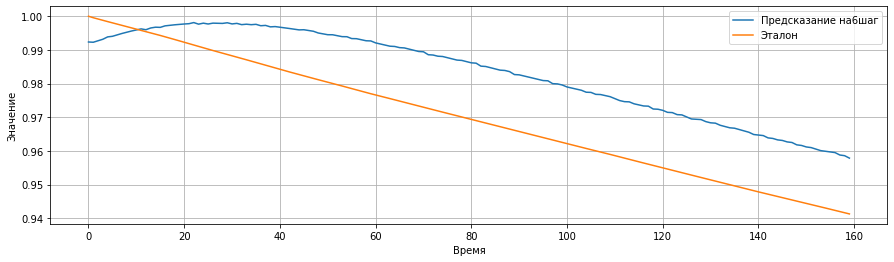

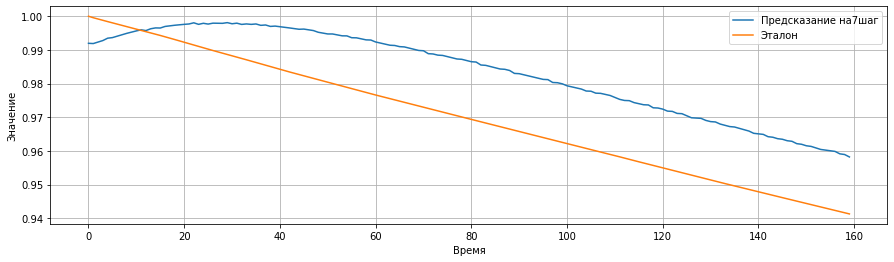

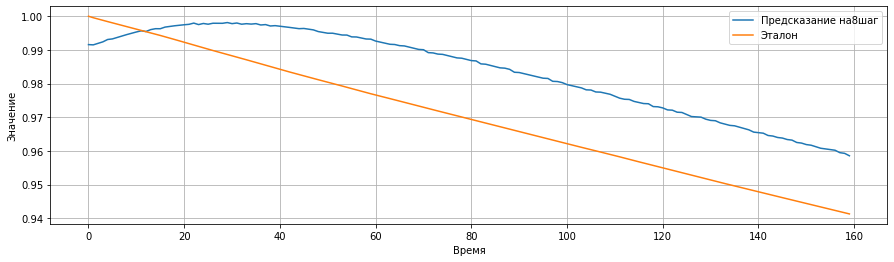

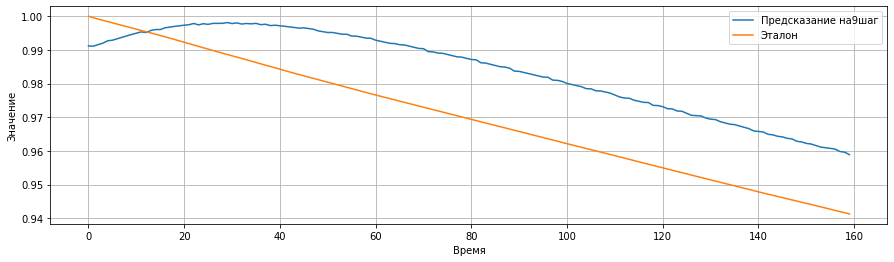

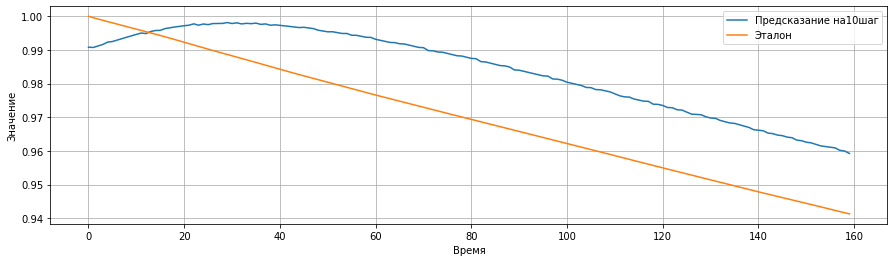

In [35]:
# функция корреляции прогноза и реальности ВИЗУАЛИЗАЦИЯ
for i in range(10):
    showCorr([i], 160, predVal, yValUnscaled)  # предсказание OPEN на 1 шаг на 160 отрезков

In [ ]:
showPredict(10000, 400, i, predVal, yValUnscaled)

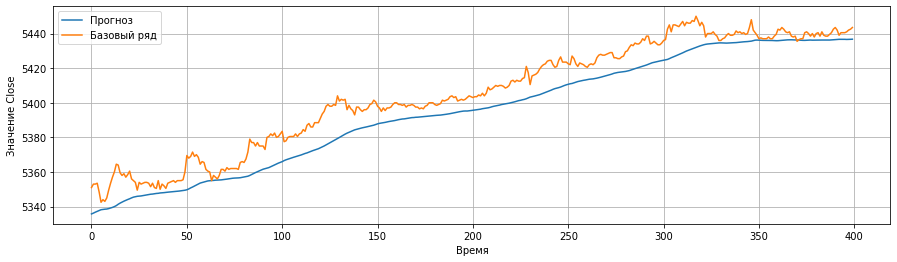

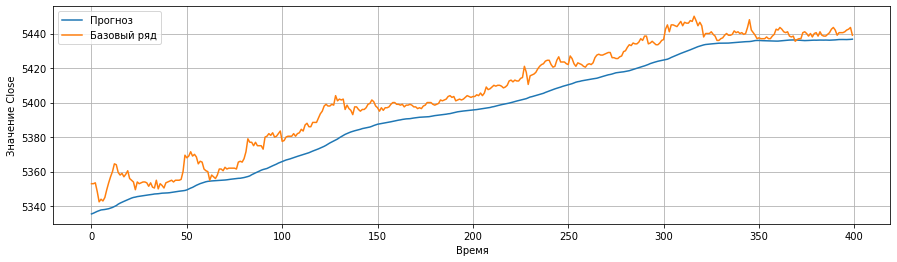

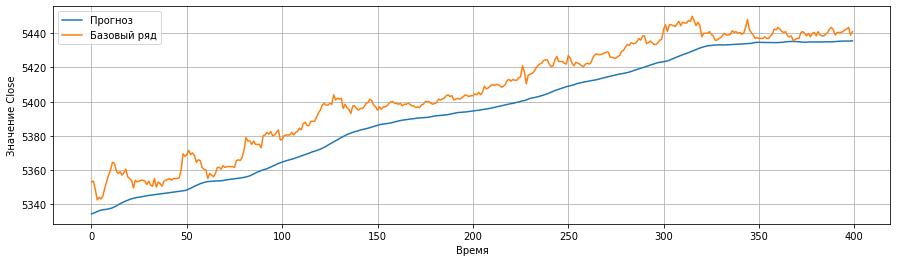

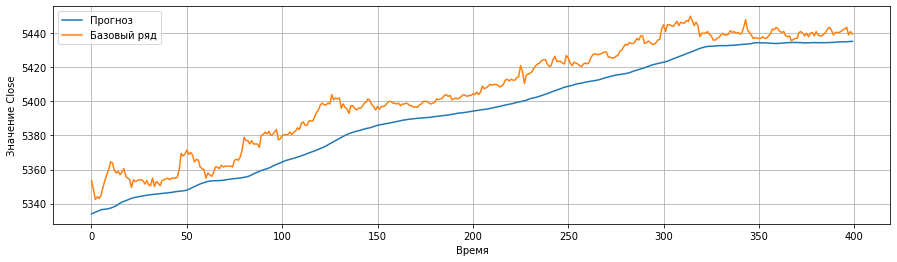

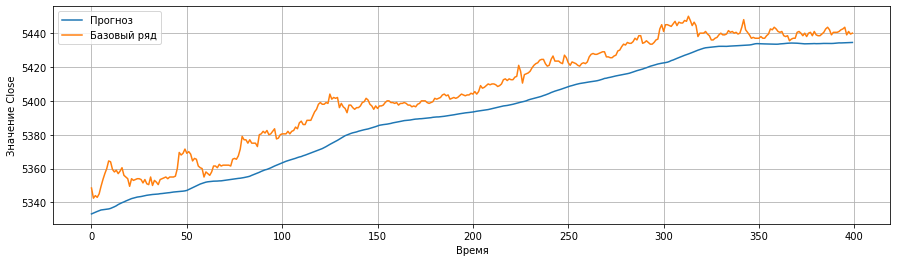

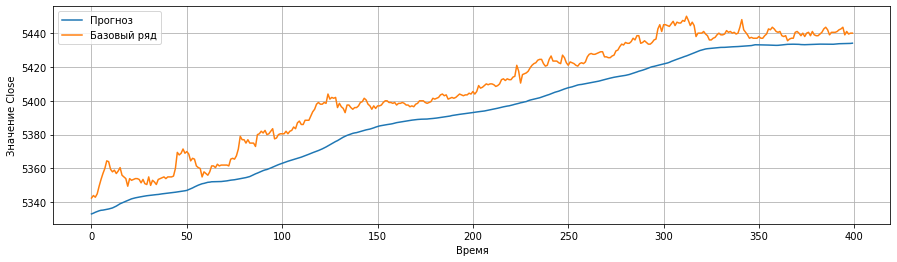

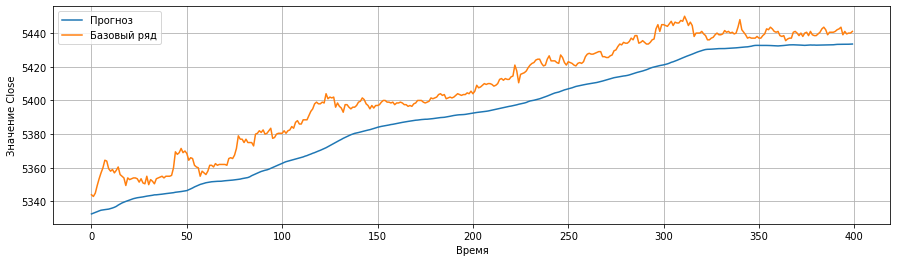

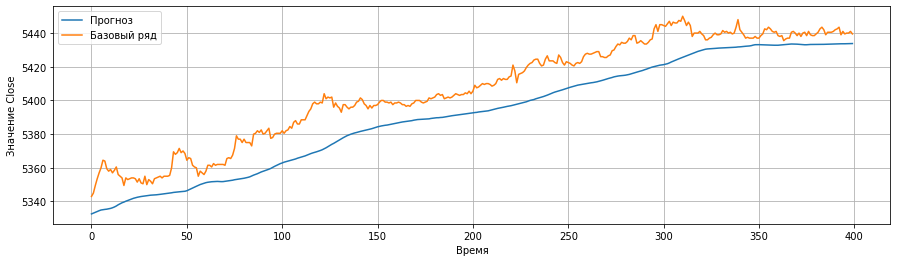

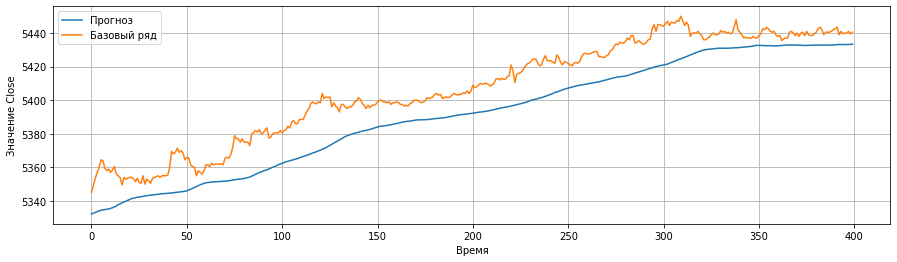

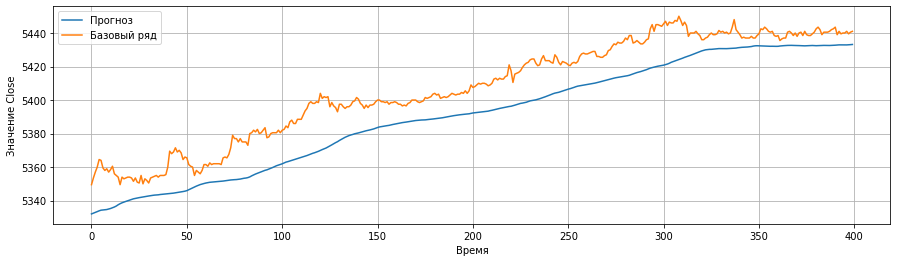

In [38]:
# функция графиков результатов прогнозирования ВИЗУАЛИЗАЦИЯ
for i in range(10):
    showPredict(10000, 400, i, predVal, yValUnscaled)

In [ ]:
# Сделал 10 предсказаний с 10 графиками.
# Перехожу к следующей сети

1


**Задание №3. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой**

In [39]:
print(yTrain.shape,yTest.shape)

(451862, 10) (29689, 10)


In [44]:
modelLSTM_Step = Sequential()                         # это сеть задания №3

modelLSTM_Step.add(LSTM(32, input_shape = (xLen, 5)))
modelLSTM_Step.add(Dropout(0.2)) 
modelLSTM_Step.add(BatchNormalization())

modelLSTM_Step.add(Dense(10, activation="linear"))
modelLSTM_Step.add(Dense(10, activation="linear"))

modelLSTM_Step.compile(loss="mse", optimizer=Adam(lr=1e-5))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
22579/22579 [==============================] - 231s 10ms/step - loss: 1.1923 - val_loss: 2.7659
Epoch 2/3
22579/22579 [==============================] - 230s 10ms/step - loss: 0.9978 - val_loss: 2.6247
Epoch 3/3
22579/22579 [==============================] - 229s 10ms/step - loss: 1.0021 - val_loss: 2.6244


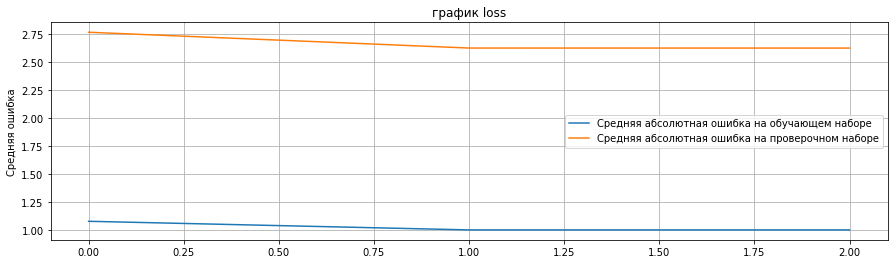

In [45]:
history = modelLSTM_Step.fit_generator(trainDataGen, epochs=3, verbose=1, validation_data=testDataGen)
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history["val_loss"], label="Средняя абсолютная ошибка на проверочном наборе")
plt.ylabel("Средняя ошибка")
plt.legend()
plt.grid()
plt.title("график loss")
plt.show()

In [46]:
currModel = modelLSTM_Step       # прогноз modelLSTM_Step
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

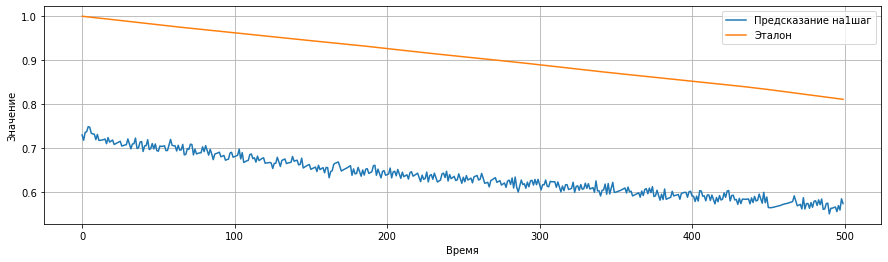

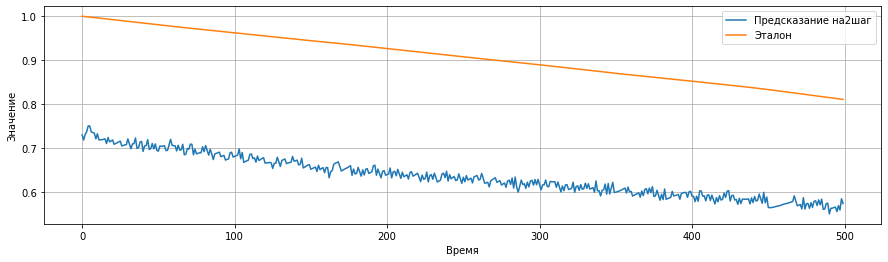

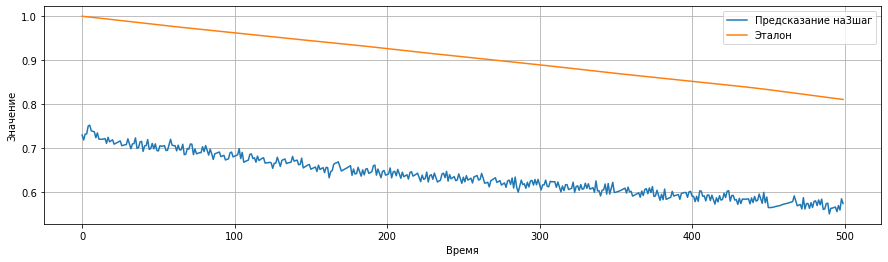

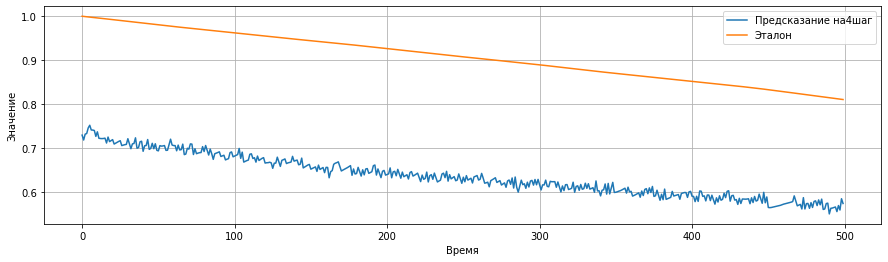

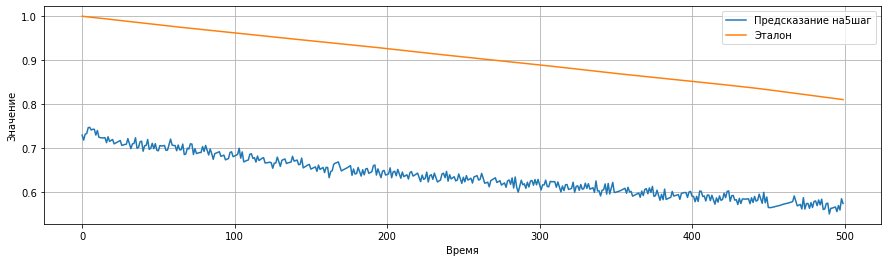

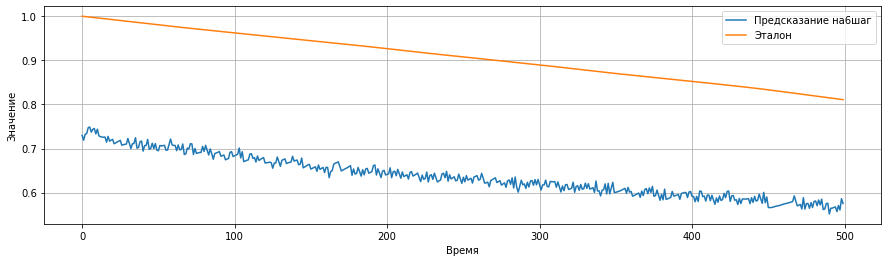

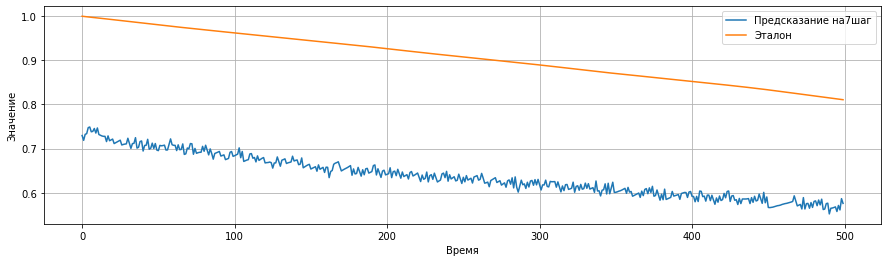

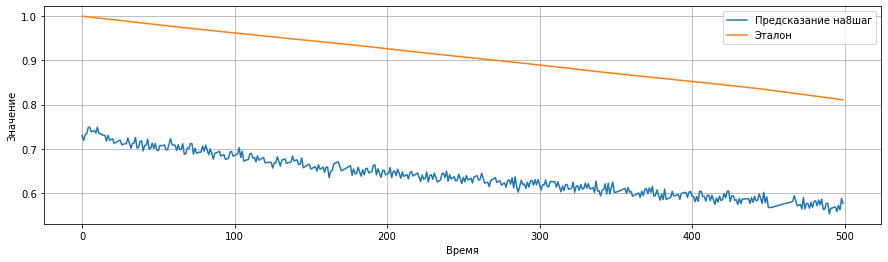

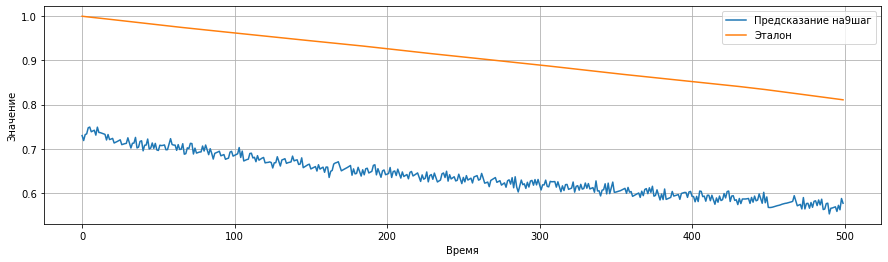

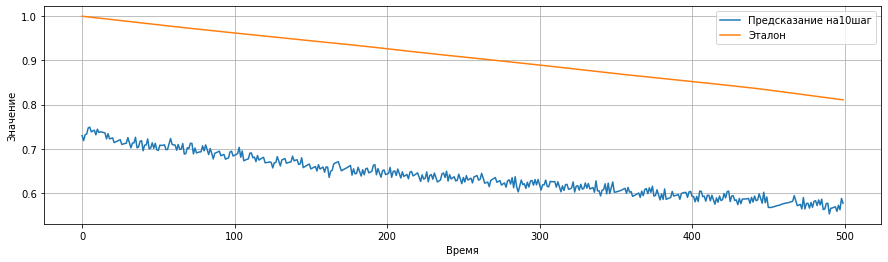

In [47]:
# функция корреляции прогноза и реальности ВИЗУАЛИЗАЦИЯ
for i in range(10):
    showCorr([i], 500, predVal, yValUnscaled)  # предсказание OPEN на 1 шаг на 500 отрезков

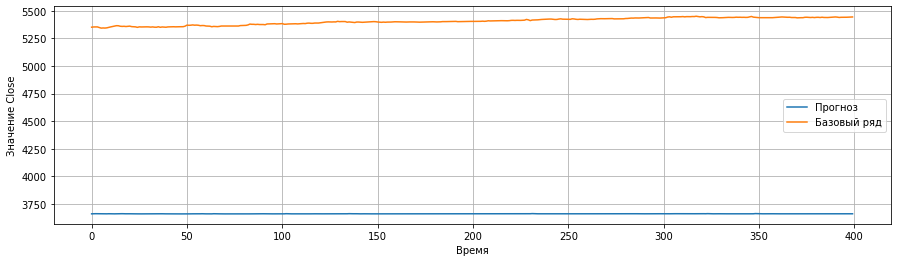

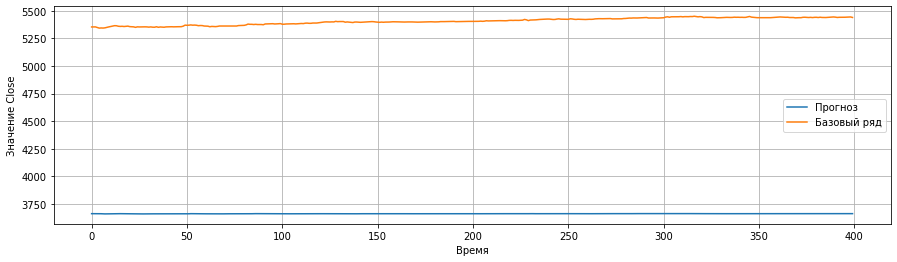

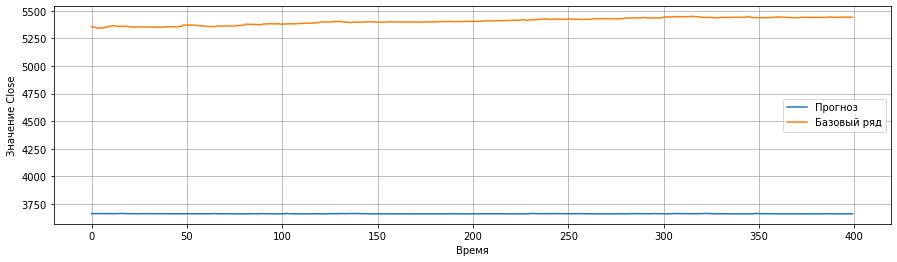

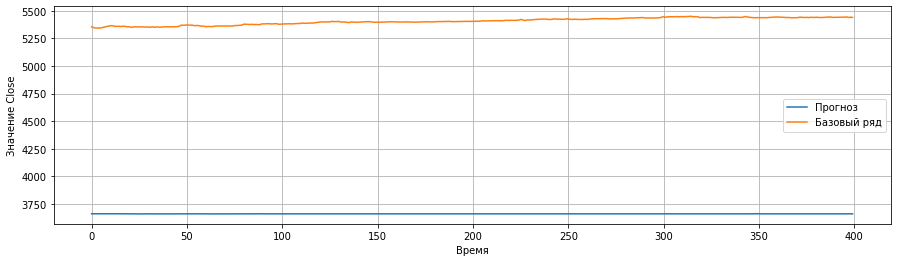

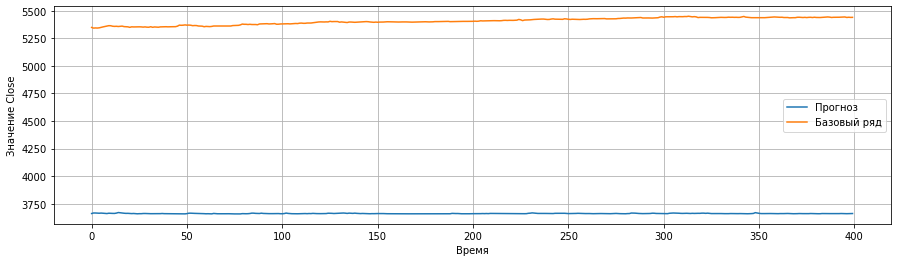

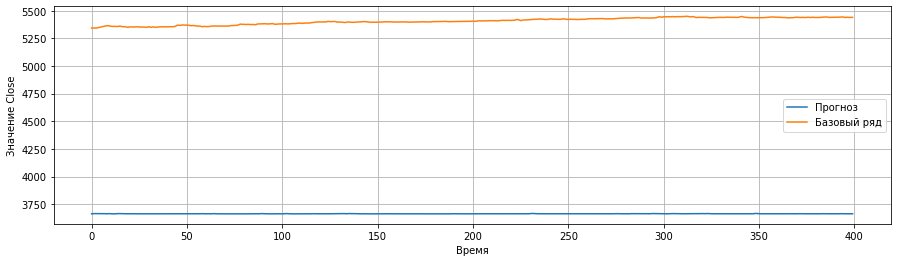

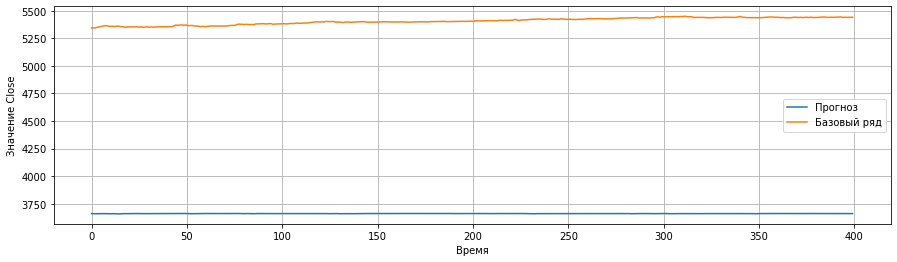

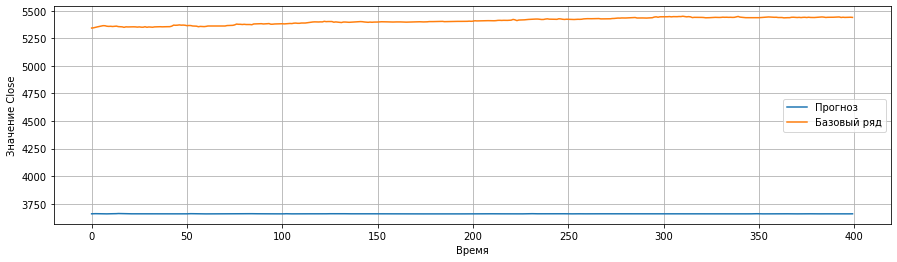

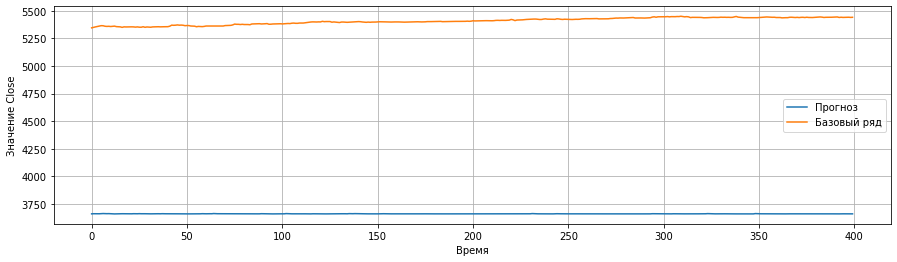

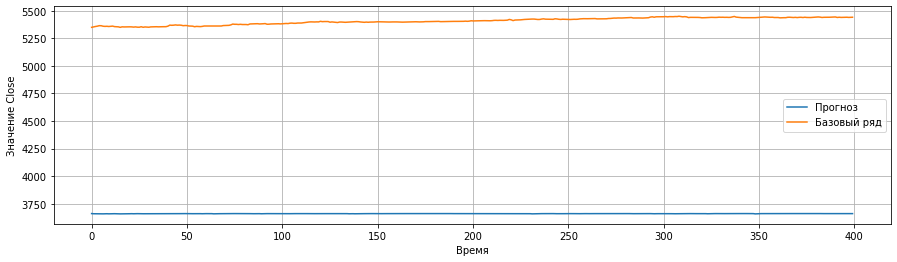

In [48]:
# функция графиков результатов прогнозирования ВИЗУАЛИЗАЦИЯ
for i in range(10):
    showPredict(10000, 400, i, predVal, yValUnscaled)

In [ ]:
# Конец экспериментов. Выполнено